In [1]:
# Importing the required libraries

import os
from os import path
from tqdm import tqdm

import cv2
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torch.utils.tensorboard import SummaryWriter

from Backend import UNet, CompositionalLoss


img_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.75)
    ,transforms.ToTensor()
    ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [2]:
class M_ImageDataset(Dataset):

    def __init__(self,test=False,transform=None):
        self.root = path.abspath(path.curdir)
        self.transform = transform
        self.traintest = 'test' if test else 'train'
        self.data = os.listdir(self.root + f'/data/{self.traintest}/')
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.model = UNet(3,3)
        self.model.load_state_dict(torch.load(self.root + '/Models/Versions/COMP/TNET COMP v4'))
        self.model.to(self.device)
        
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,index):

        if torch.is_tensor(index):
            index = index.tolist()

        item = Image.open(self.root + f'/data/{self.traintest}/' + self.data[index])
        target = Image.open(self.root + f'/matte/{self.traintest}/' + self.data[index].replace("data","matte"))
        
        if self.transform:
            item = self.transform(item).unsqueeze(0)
            target = transforms.ToTensor()(target)*255
        

        with torch.no_grad():
            output = self.model(item.to(self.device)).cpu()
            
        item = torch.cat((item,output),1).squeeze()    

      
        return item, target

In [3]:
trainset = M_ImageDataset(test=False,transform=img_transform)

trainloader = DataLoader(
    trainset,
    batch_size=1,
    shuffle=True
    )

In [4]:
EPOCHS = 4
LR = 0.001
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
CURRENT_DIR = path.abspath(path.curdir)

In [5]:
MNet = UNet(6,1)
# MNet.load_state_dict(torch.load(CURRENT_DIR + '/Models/MNET'))
MNet.to(DEVICE)
optimizer = optim.Adam(MNet.parameters(),lr=LR)
loss_function = CompositionalLoss()

In [6]:
def train(net,trainloader):
    for epoch in range(EPOCHS):
        
        avg_loss = 0
        
        for data in tqdm(trainloader): 
            
            net.zero_grad()
            
            images, trimaps = data[0].float().to(DEVICE), data[1].float().to(DEVICE)

            outputs = net(images)
            loss = loss_function(outputs,trimaps)
            loss.backward()
            optimizer.step()
            
            images.cpu()
            trimaps.cpu()          

            avg_loss += loss
        
        avg_loss /= 20592        

        print(f"Epoch: {epoch+1}. Avg Loss: {avg_loss}")
        
        torch.save(MNet.state_dict(),CURRENT_DIR + f'/Models/MNET COMP v{epoch+1}')

In [7]:
train(MNet,trainloader)

100%|██████████████████████████████████████████████████████████████████████████| 20592/20592 [5:39:57<00:00,  1.01it/s]


Epoch: 1. Avg Loss: 0.026635387912392616


100%|█████████████████████████████████████████████████████████████████████████| 20592/20592 [14:57:11<00:00,  2.61s/it]


Epoch: 2. Avg Loss: 0.02279827743768692


100%|█████████████████████████████████████████████████████████████████████████| 20592/20592 [17:16:48<00:00,  3.02s/it]


Epoch: 3. Avg Loss: 0.021609583869576454


100%|█████████████████████████████████████████████████████████████████████████| 20592/20592 [15:27:07<00:00,  2.70s/it]


Epoch: 4. Avg Loss: 0.02113754115998745


In [48]:
test_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.75)
    ,transforms.ToTensor()
    ])

testset = test_ImageDataset(test=True,transform=img_transform)

testloader = DataLoader(
    testset,
    batch_size=1,
    shuffle=True
    )

In [40]:
class test_ImageDataset(Dataset):

    def __init__(self,test=False,transform=None):
        self.root = path.abspath(path.curdir)
        self.transform = transform
        self.traintest = 'test' if test else 'train'
        self.data = os.listdir(self.root + f'/data/{self.traintest}/')
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.model = UNet(3,3)
        self.model.load_state_dict(torch.load(self.root + '/Models/Versions/COMP/TNET COMP v4'))
        self.model.to(self.device)
        
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,index):

        if torch.is_tensor(index):
            index = index.tolist()

        image = Image.open(self.root + f'/data/{self.traintest}/' + self.data[index])
        target = Image.open(self.root + f'/matte/{self.traintest}/' + self.data[index].replace("data","matte"))
        
        if self.transform:
            item = self.transform(image).unsqueeze(0)
            target = transforms.ToTensor()(target)*255
            image = test_transform(image)
        

        with torch.no_grad():
            output = self.model(item.to(self.device)).cpu()
            
        item = torch.cat((item,output),1).squeeze()    

      
        return image, output, item, target

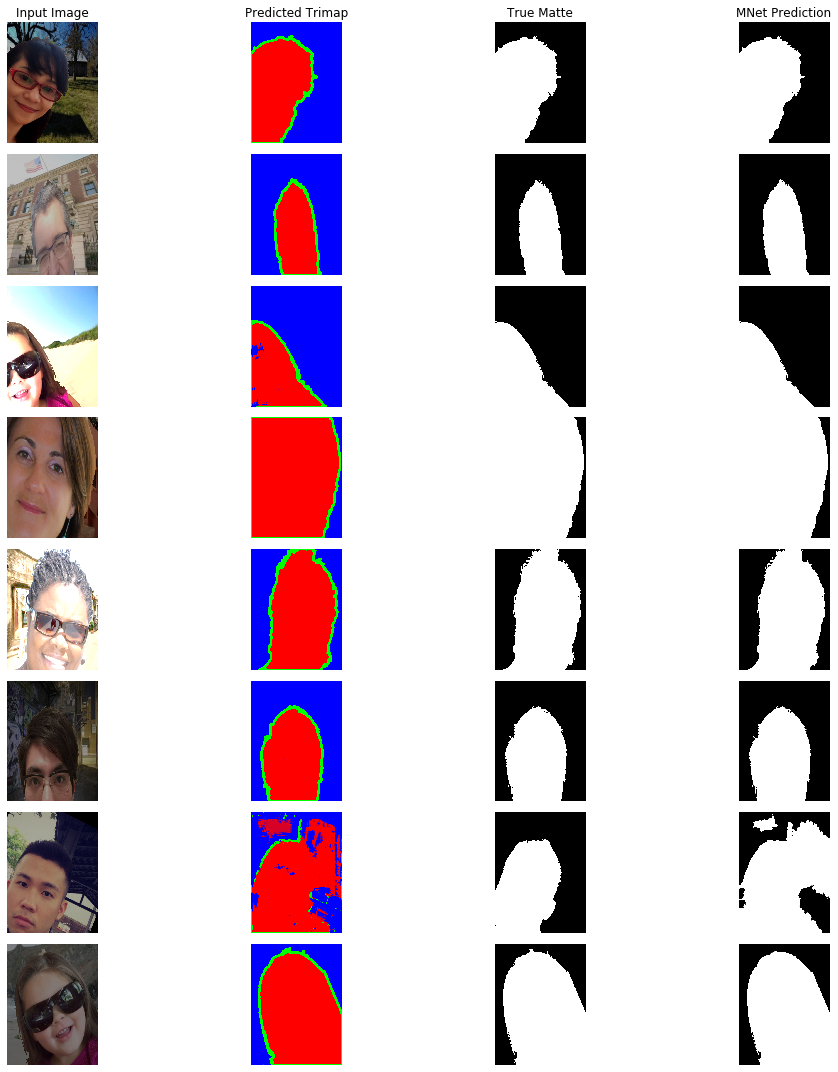

In [57]:
f, axarr = plt.subplots(8,4,figsize=(15,15))

axarr[0,0].set_title("Input Image")
axarr[0,1].set_title("Predicted Trimap")
axarr[0,2].set_title("True Matte")
axarr[0,3].set_title("MNet Prediction")


[axi.set_axis_off() for axi in axarr.ravel()]

for i in range(8):
    
    image, trimap, sample, matte = next(iter(testloader))

    test_MNet = UNet(6,1).to(DEVICE)
    test_MNet.load_state_dict(torch.load(CURRENT_DIR + '/Models/MNET COMP v4'))
    with torch.no_grad():
        output = test_MNet(sample.to(DEVICE)).cpu().squeeze(0).numpy()
    test_MNet.cpu()

    
    axarr[i,0].imshow(image.cpu().squeeze().numpy().transpose(1,2,0))
    axarr[i,1].imshow(trimap.cpu().squeeze().numpy().transpose(1,2,0))
    axarr[i,2].imshow(matte.squeeze().numpy(),cmap='gray')
    axarr[i,3].imshow(output.squeeze(),cmap='gray');


plt.tight_layout()
plt.show();

MNET RESULTS

So, as is expected, with clean trimaps we get clean alpha mattes.  When the trimap is messy, the predicted alpha matte is a slightly cleaner version of the mess (see the seventh row).  When the alpha mate has its occasional hole, it fills it in by the time the network gets to the alpha matte (see the third row).  The network also does a good job at recovering detail from areas the trimap smoothes over (see the bottom left of the hair in the last row).

The biggest problem I had was that I could not train both networks at the same time.  If I had trained MNet on the ground truth trimaps concatenated with the image I believe that I would have been able to create alpha mattes that would be essentially perfect.  The MNet seems to follow through with similar flaws that the TNet falls for (mistaking background for extension of the head, seeing pattern in shirt as the shirt ending prematurely, etc).  I could definitely benefited from a more robust training session that involved both neural networks among other improvements, but I'll save that for the end.

The Semantic Human Matting, the largest inspiration for my project, involves a final step.  They call it the fusion module and it's an attempt to reconcile uncertainty in a way that incorporates the uncertainty in the trimap.

![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/FusionModule.PNG?raw=true)

$a_{p}$ is the predicted alpha matte while $a_{r}$ is the output of MNet.  $U_{s}$ is the probability of that pixel belonging to the uncertainty region (output of TNet), $F_{s}$ and $B_{s}$ are the probabilities that the pixel is the foreground and background respectively.

In [102]:
image, trimap, sample, matte = next(iter(testloader))
trimap = trimap.squeeze()

test_MNet = UNet(6,1).to(DEVICE)
test_MNet.load_state_dict(torch.load(CURRENT_DIR + '/Models/MNET COMP v4'))
with torch.no_grad():
    output = test_MNet(sample.to(DEVICE)).cpu().squeeze(0).numpy()
test_MNet.cpu()

output = output.squeeze()

Fs = trimap[0].numpy()
Us = trimap[1].numpy()
Bs = trimap[2].numpy()

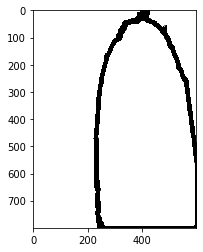

In [103]:
# Just demonstrating to my self for sanity's sake that my code is working

plt.imshow(Fs+Bs,cmap='gray')

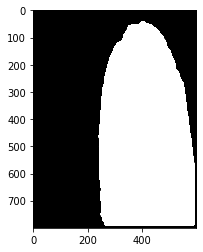

In [104]:
plt.imshow(Fs,cmap='gray')

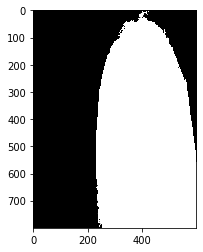

In [106]:
plt.imshow(output,cmap='gray')

In [107]:
fusion = (1-Us)

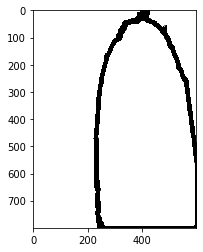

In [108]:
plt.imshow(fusion,cmap='gray')

In [120]:
new_fusion = Fs + Us*output #(1-Us)*(Fs/(Fs+Bs+0.00001)) + Us*output

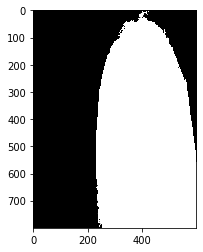

In [112]:
plt.imshow(new_fusion,cmap='gray')

In [113]:
matte = matte.squeeze().numpy()

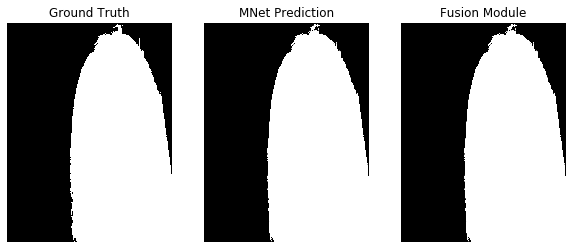

In [117]:
f, axarr = plt.subplots(1,3,figsize=(10,10))

axarr[0].set_title("Ground Truth")
axarr[1].set_title("MNet Prediction")
axarr[2].set_title("Fusion Module")

[axi.set_axis_off() for axi in axarr.ravel()]


axarr[0].imshow(matte,cmap='gray')
axarr[1].imshow(output,cmap='gray')
axarr[2].imshow(new_fusion,cmap='gray');

FUSION MODULE

From my perspective, it does not look like the fusion module is particularly helpful.  The largest thing gating my performance are the trimaps.  Initially, I thought I could help enhance the predictions including a third network that took predicted trimap and alpha matte and tried to predict the true alpha matte again.  Based on the errors with the messy trimaps and they way that the MNet handled them, I no longer thing the solution would be to stack yet another trimap on top of the process.